In [23]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

#데이터 경로 지정  
TRAIN_PATH = './data/'
# TEST_PATH = './page_data/test/'

class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('org', 'seg'))
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Normalize and resize as necessary
        image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
        mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

        # Transform to tensor
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()

        # Rearrange image dimensions to CxHxW
        image = image.permute(2, 0, 1) / 255.0  # Normalize to [0, 1]

        return image, mask

# Define any transforms you want to apply to both images and masks
transform = transforms.Compose([
    # Add any transformations here
])

# Initialize your dataset
train_dataset = CustomDataset(
    image_dir=TRAIN_PATH+'org/',
    mask_dir=TRAIN_PATH+'seg/',
    # transform=transform
)

# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)


In [24]:
from networks.unet import UNet
from torch import optim
import torch
import torch.nn as nn

model = UNet(n_channels=3, n_classes=1)
model

epoch = 5
batch_size = 1
learning_rate = 1e-5
weight_decay = 1e-8
momentum = 0.999
amp = False

optimizer = optim.RMSprop(model.parameters(),
                lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5)  # goal: maximize Dice score
# grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


In [25]:
# GPU 사용 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 모델 학습 모드 설정
model.train()

for epoch in range(epoch):
    running_loss = 0.0

    for images, masks in train_loader:
        # 데이터와 라벨을 GPU로 이동
        images = images.to(device)
        masks = masks.unsqueeze(1)
        masks = masks.to(device)

        # 옵티마이저 초기화
        optimizer.zero_grad()

        # 순전파 + 손실 계산
        outputs = model(images)
        masks = masks.float()
        loss = criterion(outputs, masks)

        # 역전파 + 옵티마이저 스텝
        loss.backward()
        optimizer.step()

        # 손실 기록
        running_loss += loss.item()

    # 에폭마다 평균 손실 출력
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

    # 선택적으로 학습률 스케줄러 스텝 실행
    # scheduler.step(epoch_loss)


Epoch 1, Loss: -281.2527
Epoch 2, Loss: -748.7574
Epoch 3, Loss: -1570.6333
Epoch 4, Loss: -2946.9877
Epoch 5, Loss: -5041.3627


In [26]:
torch.save(model, 'unet_test.pth')

In [56]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# 모델을 평가 모드로 설정
model.eval()

TEST_PATH = '../page_data/test/'

# Initialize your dataset
test_dataset = CustomDataset(
    image_dir=TEST_PATH+'org/',
    mask_dir=TEST_PATH+'seg/',
    # transform=transform
)

# Initialize DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for images, masks in test_loader:
    if isinstance(images, np.ndarray):
        images = torch.from_numpy(images).float()  # float 타입으로 변환
    images = images[0].permute(0, 3, 1, 2).cpu()

    # plt.imshow(image_to_show, cmap='gray')
    # plt.show()
    masks = masks[0].cpu().numpy()
    # plt.imshow(image_to_show, cmap='gray')
    # plt.show()
    
    outputs = model(images)
    preds = torch.sigmoid(outputs)
    preds = preds > 0.5  # 임계값을 적용하여 이진 마스크 생성
    
    # 예측된 마스크와 실제 마스크를 리스트에 추가
    predicted_masks.append(preds.cpu())
    true_masks.append(masks.cpu())
    break

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 3 is not equal to len(dims) = 4

IndexError: list index out of range

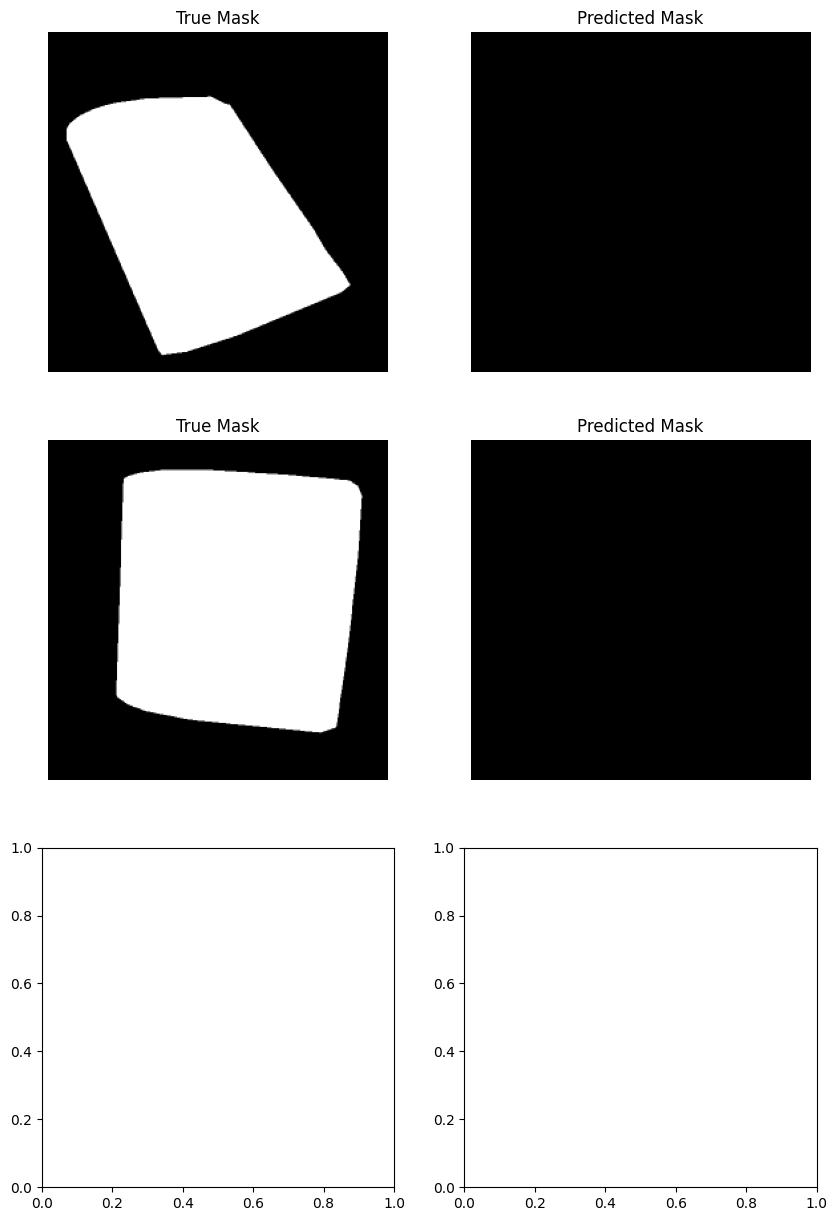

In [36]:


# 테스트 데이터에 대한 예측을 저장할 리스트 초기화
predicted_masks = []
true_masks = []

with torch.no_grad():  # 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 높임
    for images, masks in test_loader:
        # 데이터를 GPU로 이동
        images = images.to(device)
        masks = masks.to(device)

        # 모델을 통해 예측 수행
        outputs = model(images)
        
        # 여기서는 예측된 마스크를 시그모이드 함수를 적용하여 이진 분류 문제의 결과를 얻음
        preds = torch.sigmoid(outputs)
        preds = preds > 0.5  # 임계값을 적용하여 이진 마스크 생성
        
        # 예측된 마스크와 실제 마스크를 리스트에 추가
        predicted_masks.append(preds.cpu())
        true_masks.append(masks.cpu())

# 예측된 마스크와 실제 마스크를 시각화하기 위한 함수
def visualize_masks(true_masks, predicted_masks, num_examples=2):
    fig, axs = plt.subplots(num_examples, 2, figsize=(10, num_examples * 5))
    for i in range(num_examples):
        axs[i, 0].imshow(true_masks[i].squeeze(), cmap='gray')
        axs[i, 0].set_title('True Mask')
        axs[i, 1].imshow(predicted_masks[i].squeeze(), cmap='gray')
        axs[i, 1].set_title('Predicted Mask')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')
    plt.show()

# 예시로 몇 개의 마스크 시각화
visualize_masks(true_masks, predicted_masks, num_examples=3)


In [33]:
model.eval()
TEST_PATH = '../page_data/test/'

# Initialize your dataset
test_dataset = CustomDataset(
    image_dir=TEST_PATH+'org/',
    mask_dir=TEST_PATH+'seg/',
    # transform=transform
)

# Initialize DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)




NameError: name 'plt' is not defined